<a href="https://colab.research.google.com/github/coll-j/Tugas-KK/blob/master/Minggu-15-16/Final_Project_KK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

Download the data using Kaggle API

Install Kaggle pada virtual machine (VM)

In [1]:
!pip install -q kaggle

API Kaggle bisa didapatkan dari halaman akun Kaggle. API tersebut lalu dipindahkan ke VM untuk keperluan mendownload data.

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d anmolkumar/health-insurance-cross-sell-prediction

  0% 0.00/6.47M [00:00<?, ?B/s]
100% 6.47M/6.47M [00:00<00:00, 59.7MB/s]


Mengekstrak file yang terunduh

In [3]:
!unzip -q health-insurance-cross-sell-prediction.zip -d .

Menginstall beberapa kerpluan untuk menggunakan ThunderSVM. ThunderSVM merupakan model SVM dengan akselerasi GPU.

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

--2021-01-04 10:02:26--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?51AO_SJ4bVNHl7ijelgWWouCfGs6E-A6gaU5cAPtU6yWYAugXvNTNaEWaj7rGCv9HBYIR3g3R2eHPMKy3rSwEshLGFbN93e2GsHRazxOID3n43qTIUXlviMkeydijHvhuHlVTrTjiEsm4Pfk4W_KwTVq2OG95lWIWSa4QAADU_jetfgdDAJXP4asVAQCc6CODQQ58x8Trh37J8ZC5ZSw [following]
--2021-01-04 10:02:27--  https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?51AO_SJ4bVNHl7ijelgWWouCfGs6E-A6gaU5cAPtU6yWYAugXvNTNaEWaj7rGCv9HBYIR3g3R2eHPMKy3rSwEshLGFbN93e2GsHRazxOID3n43qTIUXl

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [ ]:
!pip install thundersvm

     |████████████████████████████████| 512kB 4.8MB/s 


# Imports

Import some useful libraries.

In [4]:
# utils
import pandas as pd # Data reader
import numpy as np # Linear algebra
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization
from mpl_toolkits.mplot3d import Axes3D

# models - ML based
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.tree import DecisionTreeClassifier # Decision Tree
# import thundersvm

# models - NN based
from sklearn.neural_network import MLPClassifier # Sklearn MLP
from keras.models import Sequential # Model
from keras.layers import Dense, Dropout # Layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam # Optimizer

# Additionals
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder # Normalization, Encoder
from sklearn.model_selection import train_test_split, GridSearchCV # Data splitter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif # ANOVA based feature selection
from functools import partial
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score
import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import tree

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data

Load data menggunakan library pandas

In [18]:
df = pd.read_csv('train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Mengecek apakah data ada yang duplikat

In [142]:
df.duplicated().sum()

0

Mengecek missing value

In [7]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Mengecek tipe-tipe data pada kolom

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


**Terlihat bahwa data tidak memiliki missing value. Maka, handling terhadap missing value tidak perlu dilakukan**<br>
**Data terdiri 11 kolom dengan 1 kolom target `Response`, 9 kolom fitur, dan 1 kolom id yang dapat diabaikan**

# EDA

Mengecek jumlah data pada masing-masing kelas target

In [14]:
df['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


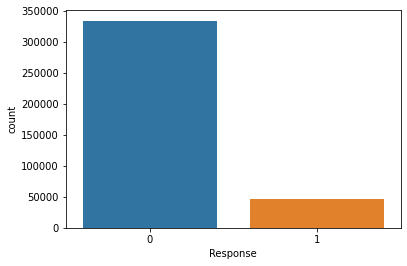

In [8]:
sns.countplot(df['Response'])

Dari countplot di atas dapat terlihat bahwa data lebih banyak memiliki target `0` atau `False`. Hal ini dapat menyebabkan model bias terhadap kelas tersebut. Ketidakrataan ini dapat diatasi dengan menyetarakan jumlah data pada kedua kelas.

Melihat distribusi umur pada masing-masing kelas

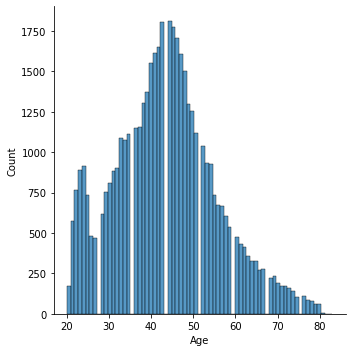

In [32]:
df_cek = df.loc[(df['Response'] == 1)]
# print(df_cek['Annual_Premium'].max())
sns.displot(df_cek['Age'])

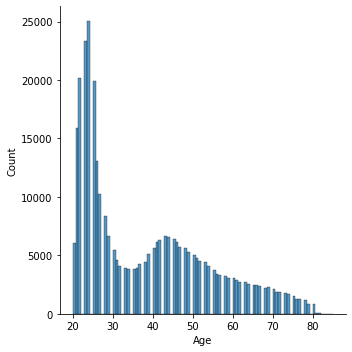

In [33]:
df_cek = df.loc[(df['Response'] == 0)]
# print(df_cek['Annual_Premium'].max())
sns.displot(df_cek['Age'])

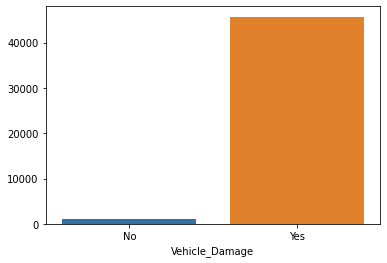

In [225]:
# fig, ax = plt.subplots(figsize=(18, 8))
df_cek = df.loc[(df['Response'] == 1)]
# print(df_cek.groupby(['Policy_Sales_Channel']).n)
sns.barplot(x=df_cek.groupby(['Vehicle_Damage']).agg(['count'])[('Age', 'count')].index, y=df_cek.groupby(['Vehicle_Damage']).agg(['count'])[('Age', 'count')].values)

                         id Gender    Age  ... Annual_Premium Vintage Response
                      count  count  count  ...          count   count    count
Policy_Sales_Channel                       ...                                
26.0                  15891  15891  15891  ...          15891   15891    15891
124.0                 13996  13996  13996  ...          13996   13996    13996
152.0                  3858   3858   3858  ...           3858    3858     3858
156.0                  2297   2297   2297  ...           2297    2297     2297
157.0                  1794   1794   1794  ...           1794    1794     1794

[5 rows x 11 columns]


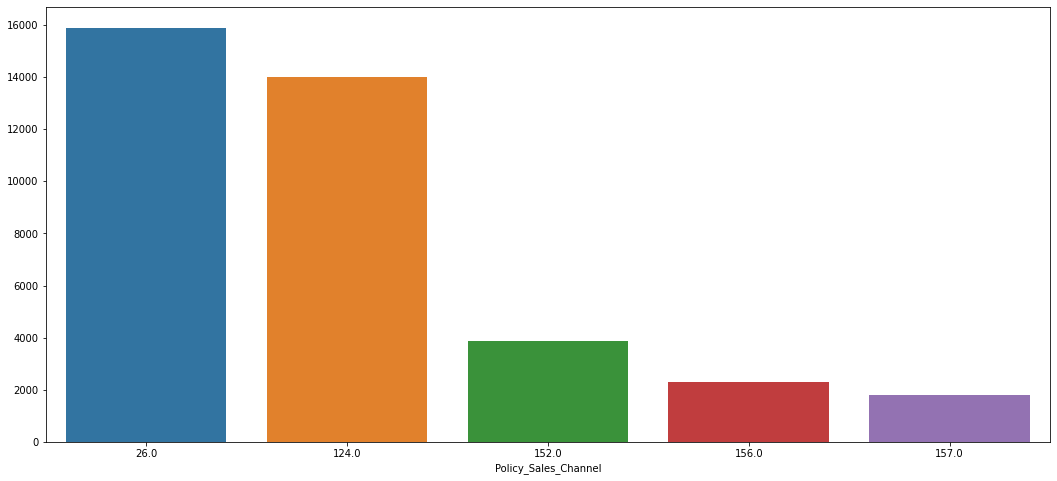

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
df_cek = df.loc[(df['Response'] == 1)]
print(df_cek.groupby(['Policy_Sales_Channel']).agg(['count']).nlargest(5, columns=[('Age', 'count')]))
sns.barplot(x=df_cek.groupby(['Policy_Sales_Channel']).agg(['count'])[('Age', 'count')].nlargest(5).index, y=df_cek.groupby(['Policy_Sales_Channel']).agg(['count'])[('Age', 'count')].nlargest(5).values, ax=ax)

            id Gender   Age  ... Annual_Premium Policy_Sales_Channel Vintage
         count  count count  ...          count                count   count
Response                     ...                                            
0           17     17    17  ...             17                   17      17
1           31     31    31  ...             31                   31      31

[2 rows x 11 columns]


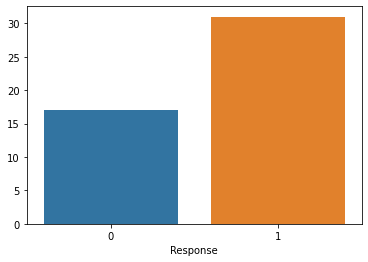

In [20]:
# fig = plt.figure(figsize=(20,8))
df_cek = df.loc[(df['Age'] >= 40) & (df['Age'] <= 50) & (df['Policy_Sales_Channel'] == 26) & (df['Previously_Insured'] == 0) & (df['Vehicle_Damage'] == 'Yes') & (df['Vehicle_Age'] == '< 1 Year')]
# print(df_cek.groupby(['Response']).count().sort_values(['id']))
print(df_cek.groupby(['Response']).agg(['count']))
sns.barplot(x=df_cek.groupby(['Response']).agg(['count'])[('Gender', 'count')].index, y=df_cek.groupby(['Response']).agg(['count'])[('Gender', 'count')].values)

Kesimpulan karakteristik pelanggan yang menerima tawaran:
- Berumur antara 40 - 50 tahun
- Dihubungi melalui media berkode 26
- Belum memiliki asuransi kendaraan
- Pernah mengalami kerusakan pada kendaraaan
- Umur kendaraan kurang dari 1 tahun

# Encoding

Encode categorical columns untuk mengubah string menjadi numerik

In [6]:
df['Vehicle_Age'].replace({'< 1 Year': int(0), '1-2 Year': int(1), '> 2 Years': int(2)}, inplace=True)
df['Vehicle_Damage'].replace({'Yes': 1, 'No': 0}, inplace=True)
df['Gender'].replace({'Male': 0, 'Female': 1}, inplace=True)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


Korelasi antara setiap fitur dengan response

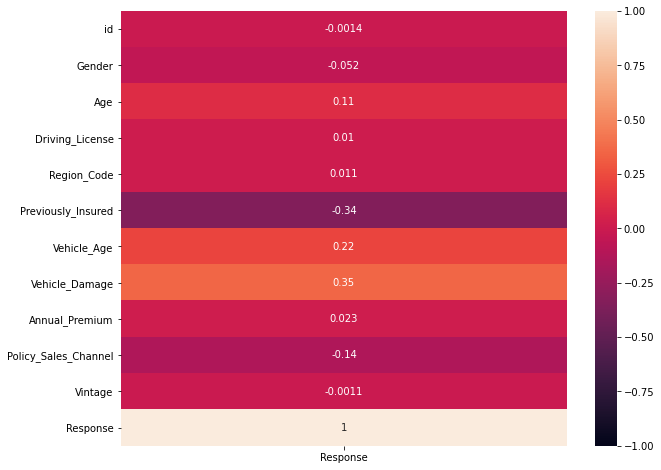

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr()[['Response']], vmin=-1, vmax=1, annot=True, ax=ax)

# Column Dropping (Feature Selection)

Dari heatmap korelasi, kota dapat men-drop beberapa kolom yg memiliki korelasi sangat rendah terhadap `Response`. Beberapa kolom yang di-drop:
- id
- Driving_License
- Region_Code
- Vintage

In [7]:
df.drop(columns=['id', 'Driving_License', 'Region_Code', 'Vintage', 'Annual_Premium', 'Gender'], inplace=True)

In [258]:
df.head()

,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response
0,44,0,2,1,26.0,1
1,76,0,1,0,26.0,0
2,47,0,2,1,26.0,1
3,21,1,0,0,152.0,0
4,29,1,0,0,152.0,0


# Normalization

In [8]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.36923077, 0.        , 1.        , 1.        , 0.15432099],
       [0.86153846, 0.        , 0.5       , 0.        , 0.15432099],
       [0.41538462, 0.        , 1.        , 1.        , 0.15432099],
       ...,
       [0.01538462, 1.        , 0.        , 0.        , 0.98148148],
       [0.73846154, 0.        , 1.        , 1.        , 0.75925926],
       [0.4       , 0.        , 0.5       , 0.        , 0.15432099]])

# Data Splitting

Undersampling untuk menyeimbangkan data.

In [9]:
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_scaled, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Splitting dengan beberapa proporsi. Penamaan variable contoh `X_train75` = data X training dengan proporsi 75% dari total data

In [10]:
X_train70, X_test30, y_train70, y_test30 = train_test_split(X_under, y_under, random_state=42, test_size=0.3)
X_train50, X_test50, y_train50, y_test50 = train_test_split(X_under, y_under, random_state=42, test_size=0.5)
X_train60, X_test40, y_train60, y_test40 = train_test_split(X_under, y_under, random_state=42, test_size=0.4)
print(len(X_train70), len(X_test30))
print(len(X_train60), len(X_test40))


65394 28026
56052 37368


In [ ]:
print(len(X_under), len(y_under))
print(len(X_test25), len(y_test25))

93420 93420
23355 23355


# Model Training

## SVM

In [ ]:
param_grid_svm = {
  'C'    : [1, 100, 10, 0.1],
  'gamma': [0.1, 0.01, 1.0],
  'kernel': ['linear', 'rbf'],
}
# grid_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid_svm)
# grid_svm.fit(X_train75, y_train75)
# grid_svm.cv_results_

In [ ]:
best_f1 = float('-inf')
best_svm = None
for kernel in param_grid_svm['kernel']:
  for c in param_grid_svm['C']:
    for gamma in param_grid_svm['gamma']:
      print('\nKernel: ', kernel, ' C: ', c, ' gamma: ', gamma)
      svm = thundersvm.SVC(kernel=kernel, C=c, gamma=gamma)
      print('Training...')
      start = time.process_time()
      svm.fit(X_train75, y_train75)
      elapsed_time = time.process_time() - start
      
      preds = svm.predict(X_test25)
      f1 = f1_score(y_test25, preds)
      acc = accuracy_score(y_test25, preds)
      if f1 > best_f1:
        best_f1 = f1
        best_svm = svm
      print('Result:')
      print('f1-score: ', f1, ' acc: ', acc, ' elapsed time: %.2fs' % elapsed_time)
      print()
print('best f1: %.2f' % best_f1)


Kernel:  linear  C:  1  gamma:  0.1
Training...
Result:
f1-score:  0.8192242711815665  acc:  0.7846713765788911  elapsed time: 4.75s


Kernel:  linear  C:  1  gamma:  0.01
Training...
Result:
f1-score:  0.8192242711815665  acc:  0.7846713765788911  elapsed time: 4.42s


Kernel:  linear  C:  1  gamma:  1.0
Training...
Result:
f1-score:  0.8192242711815665  acc:  0.7846713765788911  elapsed time: 4.44s


Kernel:  linear  C:  100  gamma:  0.1
Training...
Result:
f1-score:  0.8192242711815665  acc:  0.7846713765788911  elapsed time: 42.95s


Kernel:  linear  C:  100  gamma:  0.01
Training...
Result:
f1-score:  0.8192242711815665  acc:  0.7846713765788911  elapsed time: 42.96s


Kernel:  linear  C:  100  gamma:  1.0
Training...
Result:
f1-score:  0.8192242711815665  acc:  0.7846713765788911  elapsed time: 43.04s


Kernel:  linear  C:  10  gamma:  0.1
Training...
Result:
f1-score:  0.8192242711815665  acc:  0.7846713765788911  elapsed time: 7.03s


Kernel:  linear  C:  10  gamma:  0.01
Trai

## KNN

In [239]:
param_grid_knn = {
    'n': [3, 5, 7, 11, 31],
    'weight': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

In [245]:
best_auc = float('-inf')
best_knn = None
for n in param_grid_knn['n']:
  for weight in param_grid_knn['weight']:
    for metric in param_grid_knn['metric']:
      print('\nn_neighbor: ', n, ' weight: ', weight, ' metric: ', metric)
      knn = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
      print('Training...')
      
      start = time.process_time()
      knn.fit(X_train50, y_train50)
      elapsed_time = time.process_time() - start

      preds = knn.predict(X_test50)
      f1 = f1_score(y_test50, preds)
      auc = roc_auc_score(y_test50, preds)
      if f1 > best_auc:
        best_auc = auc
        best_f1 = f1
        best_knn = knn
        best_time = elapsed_time
      print('Result:')
      print('f1-score: ', f1, ' acc: ', auc, ' elapsed time: %.2fs' % elapsed_time)
      print()

print('best accuracy: ', best_auc, ' best f1: ', best_f1, ' time: %.2fs' % best_time)


n_neighbor:  3  weight:  uniform  metric:  euclidean
Training...
Result:
f1-score:  0.7550023895110852  acc:  0.7475714137497544  elapsed time: 1.77s


n_neighbor:  3  weight:  uniform  metric:  manhattan
Training...
Result:
f1-score:  0.7548173862431662  acc:  0.7474857606485981  elapsed time: 1.75s


n_neighbor:  3  weight:  uniform  metric:  chebyshev
Training...
Result:
f1-score:  0.7547805121383439  acc:  0.7474215391560145  elapsed time: 1.74s


n_neighbor:  3  weight:  distance  metric:  euclidean
Training...
Result:
f1-score:  0.7522556390977443  acc:  0.7460511702039613  elapsed time: 1.87s


n_neighbor:  3  weight:  distance  metric:  manhattan
Training...
Result:
f1-score:  0.7521563877112007  acc:  0.7459441276607847  elapsed time: 1.75s


n_neighbor:  3  weight:  distance  metric:  chebyshev
Training...
Result:
f1-score:  0.7521206802891646  acc:  0.7460083363200698  elapsed time: 1.74s


n_neighbor:  5  weight:  uniform  metric:  euclidean
Training...
Result:
f1-score:  

## Decision Tree

In [11]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 7, 10, 20]
}

In [12]:
best_auc = float('-inf')
best_f1 = float('-inf')
eval_metrics = 'f1'
best_dt = None
for crit in param_grid_dt['criterion']:
  for mdepth in param_grid_dt['max_depth']:
    print('\ncriterion: ', crit, ' max depth: ', mdepth)
    dt = DecisionTreeClassifier(criterion=crit, max_depth=mdepth, random_state=42)
    print('Training...')
    
    start = time.process_time()
    dt.fit(X_train50, y_train50)
    elapsed_time = time.process_time() - start

    preds = dt.predict(X_test50)
    f1 = f1_score(y_test50, preds)
    auc = roc_auc_score(y_test50, preds)
    if (f1 > best_f1):
      best_f1 = f1
      best_auc = auc
      best_dt = dt
      best_time = elapsed_time
    print('Result:')
    print('f1-score: ', f1, ' auc: ', auc, ' elapsed time: %.2fs' % elapsed_time)
    print()

print('best auc: ', best_auc, ' best f1: ', best_f1, ' time: %.2fs' % best_time)


criterion:  gini  max depth:  None
Training...
Result:
f1-score:  0.8028639806958208  auc:  0.7866230972269912  elapsed time: 0.05s


criterion:  gini  max depth:  5
Training...
Result:
f1-score:  0.8167481289140063  auc:  0.7945245701420651  elapsed time: 0.03s


criterion:  gini  max depth:  7
Training...
Result:
f1-score:  0.8183894047800273  auc:  0.7956808008412426  elapsed time: 0.04s


criterion:  gini  max depth:  10
Training...
Result:
f1-score:  0.8162668564723082  auc:  0.7955304184155458  elapsed time: 0.04s


criterion:  gini  max depth:  20
Training...
Result:
f1-score:  0.8046685230167664  auc:  0.7882502293163784  elapsed time: 0.05s


criterion:  entropy  max depth:  None
Training...
Result:
f1-score:  0.802571456829196  auc:  0.78632337187278  elapsed time: 0.05s


criterion:  entropy  max depth:  5
Training...
Result:
f1-score:  0.82373772406995  auc:  0.7932850715019328  elapsed time: 0.03s


criterion:  entropy  max depth:  7
Training...
Result:
f1-score:  0.81593

## MLP

In [265]:
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(256,256,256), learning_rate='adaptive', learning_rate_init=0.1)
start = time.process_time()
mlp.fit(X_train40, y_train60)
elapsed_time = time.process_time() - start
print('elapsed time: ', elapsed_time)

elapsed time:  174.93423360999986


In [266]:
preds = mlp.predict(X_test40)
f1_score(y_test40, preds)

0.810924885278889

# Visualisasi Prediksi

In [13]:
def printconfusion_matrix(yAsli,yPrediksi):
    # class_names=KELAS
    cnf_matrix = confusion_matrix(yAsli,yPrediksi)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix Decision Tree ')
    plt.show()
    precision, recall, fscore, support = score(yAsli,yPrediksi)
    acc = accuracy_score(yAsli,yPrediksi)

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    print('accuracy: {}'.format(acc))
    return  

In [16]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    classes = [0, 1]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix model terbaik

              precision    recall  f1-score   support

           0       0.95      0.62      0.75     23356
           1       0.72      0.97      0.82     23354

    accuracy                           0.79     46710
   macro avg       0.83      0.79      0.79     46710
weighted avg       0.83      0.79      0.79     46710

[14491  8865   791 22563]
Confusion matrix, without normalization
[[14491  8865]
 [  791 22563]]


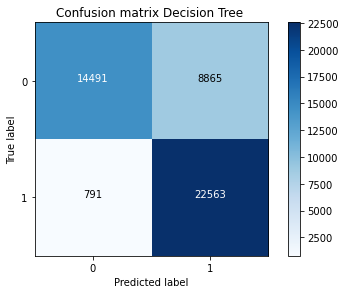

precision: [0.95 0.72]
recall: [0.62 0.97]
fscore: [0.75 0.82]
support: [23356 23354]
accuracy: 0.7932776707343181


In [17]:
preds = best_dt.predict(X_test50)
print(classification_report(y_test50, preds))
print(confusion_matrix(y_test50, preds).ravel())
printconfusion_matrix(y_test50, preds)

Representasi text dari model decision tree sebagai model terbaik.

In [70]:
col = df.drop(columns=['Response']).columns
text_representation = tree.export_text(best_dt, feature_names=['Gender', 'Age', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel'])
print(text_representation)

|--- Previously_Insured <= 0.50
|   |--- Vehicle_Damage <= 0.50
|   |   |--- Policy_Sales_Channel <= 0.94
|   |   |   |--- Age <= 0.61
|   |   |   |   |--- Age <= 0.16
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  0.16
|   |   |   |   |   |--- class: 0
|   |   |   |--- Age >  0.61
|   |   |   |   |--- Age <= 0.70
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  0.70
|   |   |   |   |   |--- class: 0
|   |   |--- Policy_Sales_Channel >  0.94
|   |   |   |--- Policy_Sales_Channel <= 0.98
|   |   |   |   |--- Policy_Sales_Channel <= 0.96
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Policy_Sales_Channel >  0.96
|   |   |   |   |   |--- class: 1
|   |   |   |--- Policy_Sales_Channel >  0.98
|   |   |   |   |--- Policy_Sales_Channel <= 0.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Policy_Sales_Channel >  0.99
|   |   |   |   |   |--- class: 0
|   |--- Vehicle_Damage >  0.50
|   |   |--- Age <= 0.12
|   |   |   |--- Policy_Sales_Channel <= 